In [1]:
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy

# Adding library directory to python search path
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [17]:
class consts:
    g = 9.81 * 10**2       # cm/s^2

class setup:
    dummy = 0

    m = 16.633 / 20               # g   -- mass of magnet
    m_err = 0.001                 # g
    r = 6.29 / 2 / 10             # cm  -- radius of magnet
    r_err = 0.01 / 10             # cm
    r_max = 12.30 / 10  + 2 * r   # cm  -- max distance between holding magnets
    r_max_err = 0.05 / 10         # cm
    
    mm = 0                        # Gauss * cm^3 -- magnetic moment
    mm_err = 0                    #
    
    B_p = 270 * 10         # Gauss -- magnetic field on magnet pole
    B_p_eps = 0.06         #

    F = 279.172 * consts.g # dyn  -- max force of attraction
    F_err = 10 * consts.g  # dyn

    T_circle = 92          # s   -- oscillation period of magnet circle
    T_err = 0.2            # s   -- time error

### Method A

In [18]:
print(setup.r_max)
mm = np.sqrt(setup.m * consts.g * setup.r_max**4 / 6)
mm_err = mm * 1/2 * np.sqrt( (4 * setup.r_max_err/setup.r_max)**2 + (setup.m_err/setup.m)**2 )
print('mm = ({} +- {}) Gauss * cm^3'.format(mm, mm_err))

B_p = 2 * mm / setup.r ** 3 
B_p_err = B_p * np.sqrt( (mm_err/mm)**2 + (3 * setup.r_err / setup.r)**2 )
print('B_p = ({} +- {}) Gauss'.format(B_p, B_p_err))

M = mm / (4/3 * 3.14 * setup.r**3)
M_err = M * np.sqrt( (mm_err/mm)**2 + (3 * setup.r_err/setup.r)**2 )
print('M = ({} +- {}) Gauss'.format(M, M_err))

B_r = 3/2 * B_p
B_r_err = B_r * B_p_err/B_p
print('B_r = ({} +- {}) Gauss'.format(B_r, B_r_err))


1.859
mm = (40.29841397723002 +- 0.2181244130937141) Gauss * cm^3
B_p = (2590.931912775755 +- 28.41641957991355) Gauss
M = (309.4265819397796 +- 3.3936806823145163) Gauss
B_r = (3886.397869163632 +- 42.62462936987033) Gauss


### Method B

In [19]:
mm = np.sqrt(8 * setup.F * setup.r**4 / (3 * 1.08) )
mm_err = mm * 1/2 * np.sqrt( (4 * setup.r_err/setup.r)**2 + (setup.F_err/setup.F)**2  )
print('mm = ({} +- {}) Gauss * cm^3'.format(mm, mm_err))

B_p = 2 * mm / setup.r ** 3 
B_p_err = B_p * np.sqrt( (mm_err/mm)**2 + (3 * setup.r_err / setup.r)**2 )
print('B_p = ({} +- {}) Gauss'.format(B_p, B_p_err))

M = mm / (4/3 * 3.14 * setup.r**3)
M_err = M * np.sqrt( (mm_err/mm)**2 + (3 * setup.r_err/setup.r)**2 )
print('M = ({} +- {}) Gauss'.format(M, M_err))

B_r = 3/2 * B_p
B_r_err = B_r * B_p_err/B_p
print('B_r = ({} +- {}) Gauss'.format(B_r, B_r_err))

# Setting magnetic moment
setup.mm = mm
setup.mm_err = mm_err

mm = (81.33626407625295 +- 1.5458439735532217) Gauss * cm^3
B_p = (5229.404868891203 +- 111.20377909360737) Gauss
M = (624.5308362529302 +- 13.280706101943554) Gauss
B_r = (7844.107303336804 +- 166.80566864041106) Gauss


## Horizontal

In [20]:
xls = {
    'T, s' : 'T'
}

h_data = mipt.read_excel("data/313.ods", usecols=range(0, 2), header=[0, 1], nrows=10)
h_data = mipt.map_excel(h_data, xls)
h_data

Horizontal          
           n         T
0         12  5.268000
1         11  4.970000
2         10  4.538000
3          9  4.100000
4          8  3.968000
5          7  3.556000
6          6  3.374000
7          5  3.323333
8          4  3.006000

In [21]:
h_fmt = {
    'Horizontal' : ['Горизонтальная составляющая'],
    ('Horizontal', 'n') : ['$n$', '{:.0f}', 0],
    ('Horizontal', 'T') : ['$T$, с', '{:.2f}', 0]
}

h_tbl = mipt.table(h_data, h_fmt)
h_tbl.rename().to_latex('gen/horizontal.tex')
h_tbl.rename().get_data()

Горизонтальная составляющая          
                          $n$    $T$, с
0                          12  5.268000
1                          11  4.970000
2                          10  4.538000
3                           9  4.100000
4                           8  3.968000
5                           7  3.556000
6                           6  3.374000
7                           5  3.323333
8                           4  3.006000

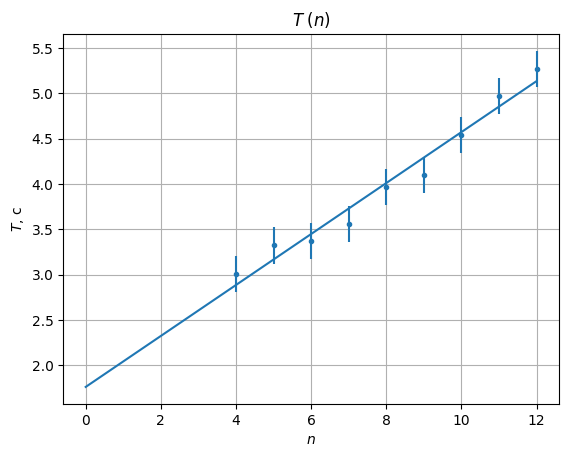

In [22]:
d = h_tbl.get_data()
x, y, equ = mipt.plot(d[('Horizontal', 'n')], d[('Horizontal', 'T')], x_min = 0, yerr = setup.T_err)

plt.title("$T \; (n)$")
plt.xlabel("$n$")
plt.ylabel("$T$, с")
plt.grid(True)

plt.savefig("gen/horizontal_Tn.pdf")


In [23]:
h_mnk = mipt.mnk(d[('Horizontal', 'n')], d[('Horizontal', 'T')], file = 'gen/horizontal_mnk.tex').get_data()
h_mnk

,<x>,sx,<y>,sy,rxy,a,da,b,db
0,8.0,6.666667,4.011481,0.542548,1.873333,0.281,0.018598,1.763481,0.156341


In [24]:
B_par = 3.14159**2 * setup.m * (setup.r * 2)**2 / (3 * setup.mm * float(h_mnk['a'])**2)
B_par_err = B_par * np.sqrt( (setup.m_err/setup.m)**2 + (setup.mm_err/setup.mm)**2
                             + (2 * setup.r_err/setup.r)**2 + (float(h_mnk['da'])/float(h_mnk['a']))**2 )
print('B_parallel = ({:.2e} +- {:.2e})'.format(B_par, B_par_err))

B_parallel = (1.69e-01 +- 1.17e-02)


## Vertical

In [25]:
xls = {
    'm, mg' : 'm',
    'l, balls' : 'l'
}

v_data = mipt.read_excel("data/313.ods", usecols=range(3, 6), header=[0, 1], nrows=5)
v_data = mipt.map_excel(v_data, xls)
v_data

Vertical          
         n    m    l
0       12  308  6.0
1       10  308  4.2
2        8  308  3.5
3        6  308  2.8
4        4  308  1.8

In [26]:
v_L = v_data[('Vertical', 'l')] * 2 * setup.r
v_L_err = setup.r

v_M = v_data[('Vertical', 'm')] * v_L * consts.g / 1000
v_M_err = v_M * v_L_err/v_L
print(v_M)

v_fmt = {
    'Vertical' : ['Вертикальная составляющая'],
    ('Vertical', 'n') : ['$n$', '{:.0f}', 0],
    ('Vertical', 'm') : ['$m$, мг', '{:.0f}', 0],
    ('Vertical', 'l') : ['$l$, шарики', '{:.1f}', 0],
    ('Vertical', 'L') : ['$l$, cм', '{:.2f}', 0],
    ('Vertical', 'M') : ['$M$, дин $\cdot$ см', '{:.0f}', 0]
}

v_tbl = mipt.table(v_data, v_fmt)
v_tbl.insert(3, ('Vertical', 'L'), v_L)
v_tbl.insert(4, ('Vertical', 'M'), v_M)
v_tbl.rename().to_latex('gen/vertical.tex')
v_tbl.rename().get_data()

0    1140.306552
1     798.214586
2     665.178822
3     532.143058
4     342.091966
dtype: float64


Вертикальная составляющая                                                
                        $n$ $m$, мг $l$, шарики $l$, cм $M$, дин $\cdot$ см
0                        12     308         6.0  3.7740         1140.306552
1                        10     308         4.2  2.6418          798.214586
2                         8     308         3.5  2.2015          665.178822
3                         6     308         2.8  1.7612          532.143058
4                         4     308         1.8  1.1322          342.091966

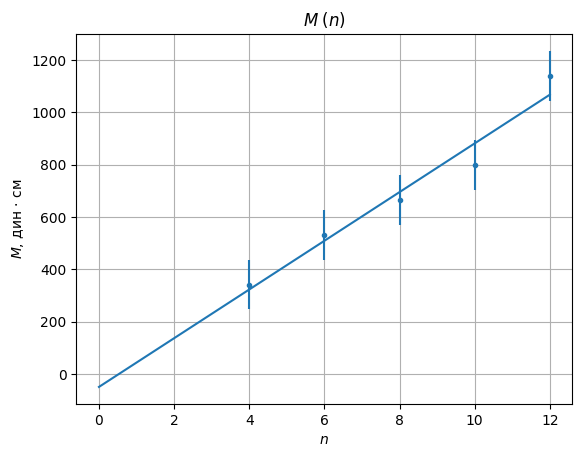

In [27]:
d = v_tbl.get_data()
x, y, equ = mipt.plot(d[('Vertical', 'n')], d[('Vertical', 'M')], x_min = 0, yerr = v_M_err)

plt.title("$M \; (n)$")
plt.xlabel("$n$")
plt.ylabel("$M$, дин $\cdot$ см")
plt.grid(True)

plt.savefig("gen/vertical_Mn.pdf")


In [28]:
v_mnk = mipt.mnk(d[('Vertical', 'n')], d[('Vertical', 'M')], file = 'gen/vertical_mnk.tex').get_data()
v_mnk

,<x>,sx,<y>,sy,rxy,a,da,b,db
0,8.0,8.0,695.586997,72181.044073,745.000281,93.125035,10.806763,-49.413284,91.698421


In [29]:
B_perp = float(v_mnk['a']) / setup.mm
B_perp_err = B_perp * np.sqrt( (setup.mm_err/setup.mm)**2 + (float(v_mnk['da'])/float(v_mnk['a']))**2 )
print('B_perp = ({:.2e} +- {:.2e})'.format(B_perp, B_perp_err))

B_perp = (1.14e+00 +- 1.35e-01)


In [30]:
beta = np.arctan(B_perp/B_par) * 180 / np.pi
print(beta)
B = (B_par ** 2 + B_perp ** 2) ** 0.5
print("{:.2f} Gauss".format(B))
print("{:.2f} nT".format(B_perp * 10 ** (-4 + 9)))
print("{:.2f} nT".format(B_par * 10 ** (-4 + 9)))


81.62557409363752
1.16 Gauss
114493.87 nT
16854.77 nT
